# Training RGCN Recommender on INSPIRED Dataset

This notebook trains the RGCN-based movie recommender on the INSPIRED dataset.

## Environmental Setup

In [1]:
import os
import sys
from pathlib import Path

# Set working directory
os.chdir("..")

# Add project root to Python path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Check current directory
current_directory = os.getcwd()
print("Project Root:", project_root)
print("Current Working Directory:", current_directory)

Project Root: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS
Current Working Directory: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS


In [2]:
!pip install -r requirements.txt

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from pathlib import Path
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

# Import NCF model and evaluator
from scripts.ncf_recommender import NCFModel, INSPIREDDataProcessor, train_ncf
from scripts.evaluator import RecommenderEvaluator

In [4]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.1+cpu
CUDA available: False
CUDA version: None
Using device: cpu


## DATA PREPARATION FOR TRAINING

### Load Dataset And Create Training Dataset

In [5]:
print("="*60)
print("STEP 1: LOAD AND PROCESS DATA")
print("="*60)

# Initialize data processor
dataset_dir = "data"
data_processor = INSPIREDDataProcessor(dataset_dir=dataset_dir)

# Load movie database
print("\nLoading movie database...")
movie_df = data_processor.load_movie_database()

# Load training dialogs
print("\nLoading training dialogs...")
data_processor.load_dialogs(split="train", max_dialogs=None)

print(f"\nData Statistics:")
print(f"  Users: {data_processor.get_num_users()}")
print(f"  Movies: {data_processor.get_num_items()}")
print(f"  Interactions: {len(data_processor.interactions)}")
print("="*60)

STEP 1: LOAD AND PROCESS DATA

Loading movie database...
Loading 17869 movies from database...
Loaded 16764 movies

Loading training dialogs...

Loading interactions from train.tsv


Processing train: 100%|██████████| 801/801 [01:02<00:00, 12.79it/s]


Interaction Summary:
  Matched: 3061
  Unmatched: 1252
  Match rate: 71.0%


Data Statistics:
  Users: 801
  Movies: 16764
  Interactions: 3061


### Initialize Model

In [6]:
print("\n" + "="*60)
print("STEP 2: INITIALIZE NCF MODEL")
print("="*60)

# Configuration
EMBEDDING_DIM = 64
MLP_LAYERS = [128, 64, 32]

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# Get actual unique items in training data
users, items, ratings = data_processor.get_train_data()
unique_items = set(items)
num_unique_items = len(unique_items)
max_item_idx = max(items)

print(f"\nData Analysis:")
print(f"  Total movies in database: {data_processor.get_num_items()}")
print(f"  Unique items in training: {num_unique_items}")
print(f"  Max item index: {max_item_idx}")
print(f"  Using max_item_idx + 1 = {max_item_idx + 1} for embeddings\n")

# Use max index + 1 for embedding size
model = NCFModel(
    num_users=data_processor.get_num_users(),
    num_items=max_item_idx + 1,  # ← FIXED
    embedding_dim=EMBEDDING_DIM,
    mlp_layers=MLP_LAYERS
)
model = model.to(device)

print(f"Model Configuration:")
print(f"  Users: {data_processor.get_num_users()}")
print(f"  Items: {data_processor.get_num_items()}")
print(f"  Embedding dim: {EMBEDDING_DIM}")
print(f"  MLP layers: {MLP_LAYERS}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print("="*60)


STEP 2: INITIALIZE NCF MODEL
Using device: cpu


Data Analysis:
  Total movies in database: 16764
  Unique items in training: 1037
  Max item index: 17816
  Using max_item_idx + 1 = 17817 for embeddings

Model Configuration:
  Users: 801
  Items: 16764
  Embedding dim: 64
  MLP layers: [128, 64, 32]
  Total parameters: 2,410,049


# TRAINING

### Training Loop

In [7]:
from pathlib import Path
import os

# Get project root
project_root = Path(os.getcwd())
if project_root.name == "notebooks":
    project_root = project_root.parent

print("="*60)
print("STEP 3: TRAINING NCF MODEL")
print("="*60)

# Training configuration
NUM_EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.001
NEGATIVE_SAMPLES = 4

# Create checkpoint directory
checkpoint_dir = project_root / "models" / "ncf_checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"\nTraining Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Negative samples: {NEGATIVE_SAMPLES}")
print(f"  Checkpoint dir: {checkpoint_dir}")
print("\n" + "-"*60 + "\n")

# Train the model
trained_model, history = train_ncf(
    model=model,
    data_processor=data_processor,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    negative_samples=NEGATIVE_SAMPLES,
    device=device
)

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)

STEP 3: TRAINING NCF MODEL

Training Configuration:
  Epochs: 10
  Batch size: 256
  Learning rate: 0.001
  Negative samples: 4
  Checkpoint dir: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS\models\ncf_checkpoints

------------------------------------------------------------

TRAINING NCF MODEL
Total interactions: 3061
Users: 801
Items: 16764
Unique items in training: 1037
Negative samples per positive: 4
Epoch 1/10 - Loss: 0.6764
Epoch 2/10 - Loss: 0.5977
Epoch 3/10 - Loss: 0.4804
Epoch 4/10 - Loss: 0.4471
Epoch 5/10 - Loss: 0.4298
Epoch 6/10 - Loss: 0.4207
Epoch 7/10 - Loss: 0.4145
Epoch 8/10 - Loss: 0.4068
Epoch 9/10 - Loss: 0.4002
Epoch 10/10 - Loss: 0.3933
Training complete!

TRAINING COMPLETE


NCF limitation: Cannot evaluate on completely new users (cold-start problem)
<br> Solution: Split each user's interactions into train/test, not users
This is why Transformer + RAG is better for conversational systems: it handles new users.

In [8]:
print("STEP 4: RUN EVALUATION WITH PROPER SPLIT")

# Get ALL training interactions
users, items, ratings = data_processor.get_train_data()
unique_items_in_training = list(set(items))

all_movie_indices = torch.tensor(
    unique_items_in_training,
    dtype=torch.long
).to(device)

print(f"Using {len(all_movie_indices)} items from training")

# FIXED: Create train/test split on SAME users
from collections import defaultdict
import random

# Group interactions by user
user_interactions = defaultdict(list)
for u, i, r in zip(users, items, ratings):
    user_interactions[u].append((i, r))

# Split each user's interactions 80/20
train_ground_truth = {}
test_ground_truth = {}

for user_idx, interactions in user_interactions.items():
    if len(interactions) < 2:  # Skip users with only 1 interaction
        continue
    
    # Shuffle interactions
    interactions = list(interactions)
    random.shuffle(interactions)
    
    # 80/20 split
    split_point = int(0.8 * len(interactions))
    train_items = [item for item, rating in interactions[:split_point]]
    test_items = [item for item, rating in interactions[split_point:]]
    
    if test_items:  # Only include users with test items
        train_ground_truth[user_idx] = set(train_items)
        test_ground_truth[user_idx] = set(test_items)

print(f"\nEvaluation setup:")
print(f"  Users in evaluation: {len(test_ground_truth)}")
print(f"  Train interactions per user: {sum(len(v) for v in train_ground_truth.values()) / len(train_ground_truth):.1f} avg")
print(f"  Test interactions per user: {sum(len(v) for v in test_ground_truth.values()) / len(test_ground_truth):.1f} avg")

# Initialize evaluator
evaluator = RecommenderEvaluator(k_values=[1, 3, 5, 10])

# Evaluate
test_users = list(test_ground_truth.keys())[:100]
print(f"\nEvaluating on {len(test_users)} users...\n")

predictions = []

for user_idx in tqdm(test_users, desc="Generating predictions"):
    # Get recommendations
    recommendations = trained_model.predict_top_k(
        user_idx=user_idx,
        candidate_items=all_movie_indices,
        k=10
    )
    
    recommended_ids = [rec['item_idx'] for rec in recommendations]
    
    predictions.append({
        'recommended': recommended_ids,
        'ground_truth': test_ground_truth[user_idx]
    })

# Evaluate
print("\nComputing metrics...")
results = evaluator.evaluate_batch(predictions)

# Print results
evaluator.print_results(
    dataset_name="NCF Test Set (Same Users, Held-out Items)",
    num_samples=len(predictions)
)

# Save results
evaluator.save_results(
    output_path=str(checkpoint_dir / "evaluation_results.json"),
    model_name="NCF",
    metadata={
        'num_users': len(test_ground_truth),
        'num_items': len(unique_items_in_training),
        'test_samples': len(predictions),
        'evaluation_type': 'same_users_holdout_items'
    }
)

print("="*60)

STEP 4: RUN EVALUATION WITH PROPER SPLIT
Using 1037 items from training

Evaluation setup:
  Users in evaluation: 654
  Train interactions per user: 2.6 avg
  Test interactions per user: 1.3 avg

Evaluating on 100 users...



Generating predictions: 100%|██████████| 100/100 [00:00<00:00, 426.62it/s]


Computing metrics...

EVALUATION RESULTS

Dataset: NCF Test Set (Same Users, Held-out Items)
Number of samples: 100

HIT:
  @ 1: 0.0600
  @ 3: 0.1200
  @ 5: 0.1800
  @10: 0.2500

MRR:
  @ 1: 0.0600
  @ 3: 0.0883
  @ 5: 0.1013
  @10: 0.1111

NDCG:
  @ 1: 0.0600
  @ 3: 0.0782
  @ 5: 0.1035
  @10: 0.1272

Recall:
  @ 1: 0.0433
  @ 3: 0.0900
  @ 5: 0.1500
  @10: 0.2183

Results saved to: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS\models\ncf_checkpoints\evaluation_results.json


### Save Final Model

In [9]:
print("\n" + "="*60)
print("STEP 4: SAVING MODEL")
print("="*60)

# Save checkpoint
checkpoint_path = checkpoint_dir / "ncf_model.pt"

torch.save({
    'model_state_dict': trained_model.state_dict(),
    'num_users': data_processor.get_num_users(),
    'num_items': data_processor.get_num_items(),
    'embedding_dim': EMBEDDING_DIM,
    'mlp_layers': MLP_LAYERS,
    'user_to_idx': data_processor.user_to_idx,
    'idx_to_user': data_processor.idx_to_user,
    'movie_to_idx': data_processor.movie_to_idx,
    'idx_to_movie': data_processor.idx_to_movie,
    'training_config': {
        'num_epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'negative_samples': NEGATIVE_SAMPLES
    }
}, checkpoint_path)

print(f"Model saved to: {checkpoint_path}")

# Save training history
history_path = checkpoint_dir / "training_history.json"
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"Training history saved to: {history_path}")
print("="*60)


STEP 4: SAVING MODEL
Model saved to: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS\models\ncf_checkpoints\ncf_model.pt
Training history saved to: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS\models\ncf_checkpoints\training_history.json


### VIZ TRAINING HISTORY

## PLOT TRAINING HISTORY

Interactive plot saved to: models\rgcn_checkpoints\training_plot.html
  Open this file in your web browser to view the plot
  (PNG export requires kaleido: pip install kaleido)


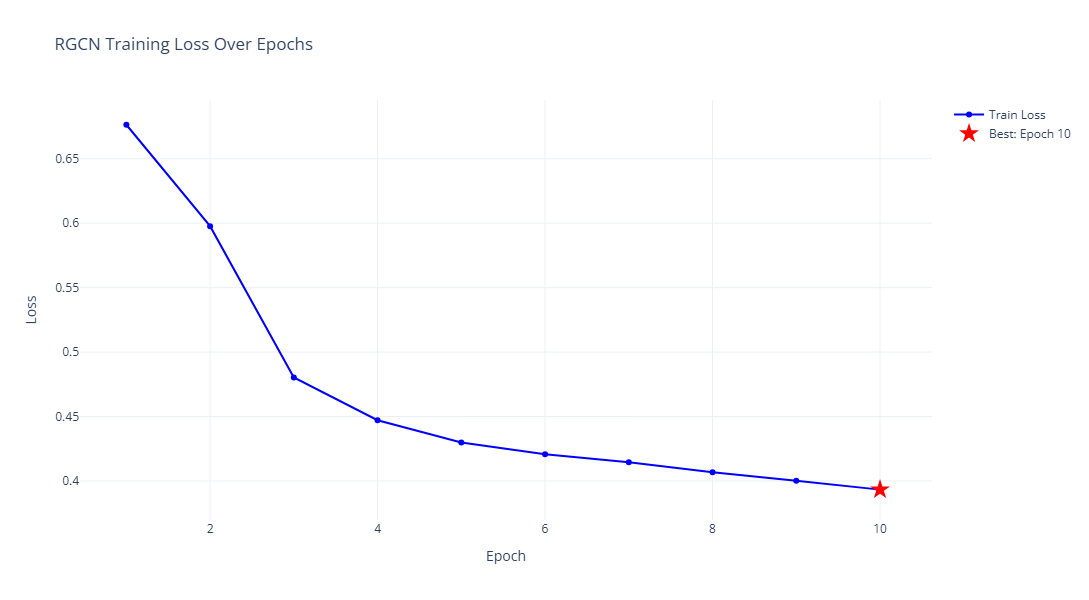


Best epoch: 10 with loss: 0.3933


In [10]:
import json
from pathlib import Path

# Install plotly if needed
try:
    import plotly.graph_objects as go
except ImportError:
    print("Installing plotly...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'plotly'])
    import plotly.graph_objects as go

# Load the saved history
history_path = checkpoint_dir / "training_history.json"

if not history_path.exists():
    print(f"File not found: {history_path}")
else:
    with open(history_path, 'r') as f:
        history = json.load(f)
    
    # Find best epoch
    best_epoch_idx = history['train_loss'].index(min(history['train_loss']))
    best_epoch = history['epoch'][best_epoch_idx]
    best_loss = history['train_loss'][best_epoch_idx]
    
    # Create interactive plot with Plotly
    fig = go.Figure()
    
    # Add training loss line
    fig.add_trace(go.Scatter(
        x=history['epoch'],
        y=history['train_loss'],
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='blue', width=2),
        marker=dict(size=6)
    ))
    
    # Add best epoch marker
    fig.add_trace(go.Scatter(
        x=[best_epoch],
        y=[best_loss],
        mode='markers',
        name=f'Best: Epoch {best_epoch}',
        marker=dict(size=15, color='red', symbol='star')
    ))
    
    # Update layout
    fig.update_layout(
        title='RGCN Training Loss Over Epochs',
        xaxis_title='Epoch',
        yaxis_title='Loss',
        hovermode='x unified',
        template='plotly_white',
        width=1000,
        height=600
    )
    
    # Save as interactive HTML
    html_path = Path("models/rgcn_checkpoints/training_plot.html")
    fig.write_html(str(html_path))
    print(f"Interactive plot saved to: {html_path}")
    print(f"  Open this file in your web browser to view the plot")
    
    # Also save as static image (PNG)
    try:
        png_path = Path("models/rgcn_checkpoints/training_plot.png")
        fig.write_image(str(png_path))
        print(f"Static plot saved to: {png_path}")
    except:
        print("  (PNG export requires kaleido: pip install kaleido)")
    
    # Display in notebook (should be stable)
    fig.show()
    
    print(f"\nBest epoch: {best_epoch} with loss: {best_loss:.4f}")

In [11]:
print("\n" + "="*60)
print("STEP 6: TEST MODEL")
print("="*60)

# Test on sample user
sample_users = list(data_processor.user_to_idx.keys())[:3]

for user_id in sample_users:
    user_idx = data_processor.user_to_idx[user_id]
    
    print(f"\nUser: {user_id}")
    print(f"Top-5 Recommendations:")
    
    recommendations = trained_model.predict_top_k(
        user_idx=user_idx,
        candidate_items=all_movie_indices,
        k=5
    )
    
    for i, rec in enumerate(recommendations, 1):
        movie_name = data_processor.idx_to_movie[rec['item_idx']]
        print(f"  {i}. {movie_name} (score: {rec['score']:.4f})")

print("\n" + "="*60)
print("Training complete! Run NCF.ipynb for evaluation.")
print("="*60)


STEP 6: TEST MODEL

User: 20191126-061250_477_live.pkl
Top-5 Recommendations:
  1. Joker (score: 1.5275)
  2. Frozen (score: 1.4661)
  3. Avengers: Endgame (score: 1.4516)
  4. Knives Out (score: 1.3036)
  5. John Wick (score: 1.2625)

User: 20191126-112230_370_live.pkl
Top-5 Recommendations:
  1. Joker (score: 1.0952)
  2. Frozen (score: 0.8764)
  3. Avengers: Endgame (score: 0.8655)
  4. Knives Out (score: 0.7539)
  5. John Wick (score: 0.7164)

User: 20191126-114841_816_live.pkl
Top-5 Recommendations:
  1. Joker (score: 1.6142)
  2. Frozen (score: 1.5275)
  3. Avengers: Endgame (score: 1.4801)
  4. Knives Out (score: 1.4116)
  5. Zombieland (score: 1.3932)

Training complete! Run NCF.ipynb for evaluation.


## Test Trained Model